In [0]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, adjusted_mutual_info_score as ami

# Load data

In [0]:
random_seed = 1
wine = 'winequality-white.csv'
df = df = pd.read_csv(wine, sep=';')
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
# Standardize
X_std = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)
# X, X_test, Y, Y_test = train_test_split(data_X, data_y, train_size=0.8, random_state=random_seed)

# PCA

In [0]:
def pca(X, Y, random_seed, no_features, ds_name):
  cum_var = []
  fit_time = []
  # max components = no features
  comp = range(1, no_features+1)
  
  for i in comp:
    pca = PCA(n_components = i)
    start = datetime.datetime.now()
    pca.fit(X)
    finish = datetime.datetime.now()
    fit_time.append((finish - start).total_seconds())
    # Get the PCs into X
    # X = pca.transform(X)
    cum_var.append(np.sum(pca.explained_variance_ratio_))
  
  # Variance for all 11 principal components
  var = pca.explained_variance_ratio_
  # Plot PCA
  plt.plot(comp,cum_var, label='Cumulative variance', marker='o')
  plt.plot(comp,var, label='Explained variance', marker='o')
  plt.title('PCA - ' + ds_name)
  plt.xlabel('Number of principal components')
  plt.ylabel('Explained variance')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

  print(*comp)
  print('PCA - cum variance')
  print(cum_var)
  print('PCA - variance')
  print(var)
  print('Principal components - Fit times')
  print(fit_time)

# Clustering code

In [0]:
from sklearn.metrics import v_measure_score
def kmeans(X, Y, random_seed, ds_name):
  wcss = []
  homo = []
  comp = []
  ami_score = []
  sil_score = []
  v_score = []
  fit_time = []
  # we know no labels = 7
  k_vals = range(2, 11)
  for i in k_vals:
      kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_seed)
      start = datetime.datetime.now()
      kmeans.fit(X)
      finish = datetime.datetime.now()
      fit_time.append((finish - start).total_seconds())
      labels_pred = kmeans.labels_
      wcss.append(kmeans.inertia_)
      sil_score.append(silhouette_score(X, labels_pred , metric='euclidean'))
      ami_score.append(ami(Y, labels_pred))
      homo.append(homogeneity_score(Y, labels_pred))
      comp.append(completeness_score(Y, labels_pred))
      v_score.append(v_measure_score(Y, labels_pred))

  # Plot Elbow
  plt.plot(k_vals,wcss, marker='o')
  plt.title('K means - Elbow Method - ' + ds_name)
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.grid()
  plt.show()

  # Scores
  # plt.plot(k_vals, sil_score, label='Silhoutte score')
  plt.plot(k_vals,ami_score, label='Adj Mutual Info', marker='o')
  plt.plot(k_vals,homo, label='Homogeneity', marker='o')
  plt.plot(k_vals,comp, label='Completeness', marker='o')
  plt.plot(k_vals,v_score, label='V-measure', marker='o')
  #TODO: Plot time as well
  plt.title('K means - Evaluation Scores - ' + ds_name)
  plt.xlabel('Number of clusters')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.show()

def em(X, Y, random_seed, ds_name):
  bic = []
  homo = []
  comp = []
  ami_score = []
  sil_score = []
  v_score = []
  fit_time = []
  # we know no labels = 7
  k_vals = range(2, 11)
  for i in k_vals:
      gmm = GMM(n_components=i, random_state=random_seed)
      start = datetime.datetime.now()
      gmm.fit(X)
      finish = datetime.datetime.now()
      fit_time.append((finish - start).total_seconds())
      #BIC score (lower better)
      bic.append(gmm.bic(X))
      labels_pred = gmm.predict(X)
      sil_score.append(silhouette_score(X, labels_pred , metric='euclidean'))
      ami_score.append(ami(Y, labels_pred))
      homo.append(homogeneity_score(Y, labels_pred))
      comp.append(completeness_score(Y, labels_pred))
      v_score.append(v_measure_score(Y, labels_pred))

  # Plot Elbow
  plt.plot(k_vals,bic, marker='o')
  plt.title('EM - BIC to choose optimal components - ' + ds_name)
  plt.xlabel('Number of components')
  plt.ylabel('BIC')
  plt.grid()
  plt.show()

  # Scores
  # plt.plot(k_vals, sil_score, label='Silhoutte score')
  plt.plot(k_vals,ami_score, label='Adj Mutual Info', marker='o')
  plt.plot(k_vals,homo, label='Homogeneity', marker='o')
  plt.plot(k_vals,comp, label='Completeness', marker='o')
  plt.plot(k_vals,v_score, label='V-measure', marker='o')
  #TODO: Plot time as well
  plt.title('EM - Evaluation Scores - ' + ds_name)
  plt.xlabel('Number of components')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.show()


# Visualization K means & EM

In [0]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, ds_name, n_clusters=4, rseed=0, ax=None):
    plt.title("PCA - K means - " + ds_name)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, ds_name, label=True, ax=None):
    plt.title("PCA - K means - " + ds_name)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

# Neural Networks Code

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
def NN(X, Y, plt_title, random_seed=1):
    # Hyperparameter tuning, hidden layer size
    X_train, X_val_test, y_train, y_val_test = \
        train_test_split(X, Y, train_size=0.8, random_state=random_seed)
    hidden_layer_sizes = [2, 4, 6, 8, 10]
    train_score = []
    test_score = []
    for i in hidden_layer_sizes:
        mlp_model = MLPClassifier(hidden_layer_sizes=(i,),random_state=random_seed)
        mlp_model.fit(X=X_train, y=y_train)
        y_train_predict = mlp_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        train_score.append(train_accuracy)

        y_val_test_predict = mlp_model.predict(X_val_test)
        test_accuracy = accuracy_score(y_val_test, y_val_test_predict)
        test_score.append(test_accuracy)

    df_layers = pd.DataFrame({
        'Hidden layer sizes': hidden_layer_sizes,
        'train score': train_score,
        'validation score': test_score
    })
    print('Hidden layers**************')
    print(df_layers)
    print('hidden_layer_sizes: ', hidden_layer_sizes)
    print('train_score: ', train_score)
    print('test_score: ', test_score)

    # Plot Max depth
    plt.plot(hidden_layer_sizes, train_score, 'o-', color="r",
              label="Training score")
    plt.plot(hidden_layer_sizes, test_score, 'o-', color="g",
              label="Test score")
    plt.legend(loc="best")
    plt.xlabel('Hidden layer sizes')
    plt.ylabel('Accuracy Score')
    plt.title(plt_title)
    plt.show()

# PCA - Wine Dataset

PCA - Wine Dataset


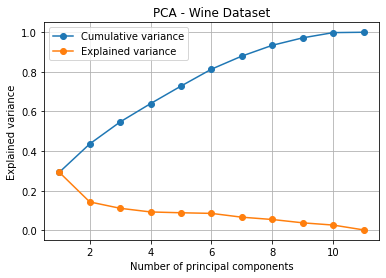

1 2 3 4 5 6 7 8 9 10 11
PCA - cum variance
[0.2929321718756496, 0.43613580197390067, 0.5471968328697149, 0.6397897742033949, 0.7282747359911346, 0.8136148733941038, 0.8796692391167443, 0.9341563736297458, 0.9718057977884462, 0.9981228103856539, 1.0]
PCA - variance
[0.29293217 0.14320363 0.11106103 0.09259294 0.08848496 0.08534014
 0.06605437 0.05448713 0.03764942 0.02631701 0.00187719]
Principal components - Fit times
[0.022497, 0.008776, 0.008776, 0.008825, 0.009147, 0.008734, 0.008948, 0.009158, 0.002968, 0.002978, 0.002978]


In [30]:
print('PCA - Wine Dataset')
pca(X=X_std, Y=Y, random_seed=random_seed, no_features=11, ds_name = 'Wine Dataset')

# PCA with K means Wine dataset

Wine Dataset choosing Principal components = 7 (cum_var = 0.87966)

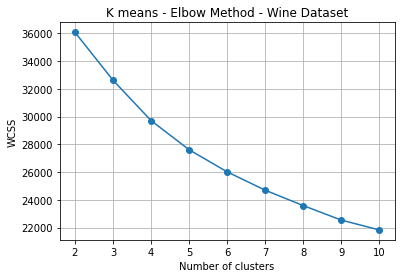

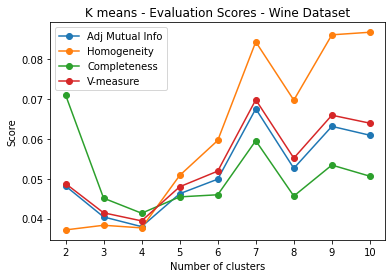

In [31]:
pca1 = PCA(n_components=7)
pca1.fit(X_std)
X_reduced = pca1.transform(X_std)
np.sum(pca1.explained_variance_ratio_)
kmeans(X=X_reduced, Y=Y, random_seed=random_seed, ds_name='Wine Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'K means clusters - Wine Dataset')

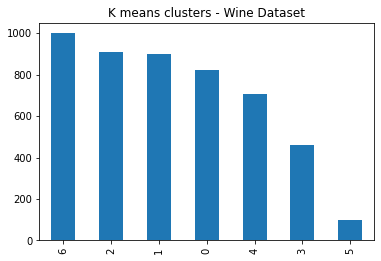

In [32]:
# Choosing k=7 appx from elbow and score peak
kmeans1 = KMeans(n_clusters=7, init='k-means++', random_state=random_seed)
kmeans1.fit(X_reduced)
labels_pred_k = pd.DataFrame(data = kmeans1.labels_, columns=['Cluster labels'])
labels_pred_k['Cluster labels'].value_counts().plot('bar')
plt.title('K means clusters - Wine Dataset')

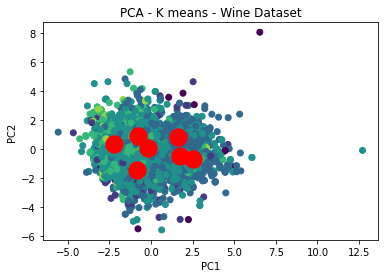

In [33]:
# Visualization of clusters & labels using PCA
plt.title("PCA - K means - Wine Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=Y)
plt.scatter(kmeans1.cluster_centers_[:, 0], kmeans1.cluster_centers_[:, 1], s=300, c='red')

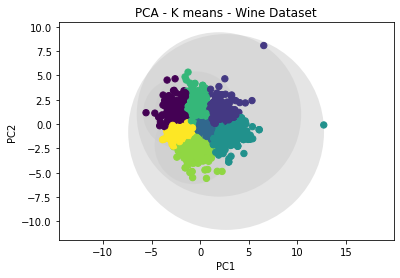

In [34]:
plot_kmeans(kmeans=kmeans1, X=X_reduced[:,0:2], n_clusters=7, ds_name='Wine Dataset',rseed=random_seed)

# PCA with Neural Networks - Wine Dataset 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.521184          0.480612
1                   4     0.539561          0.490816
2                   6     0.543900          0.498980
3                   8     0.552833          0.502041
4                  10     0.558448          0.507143
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.5211842776927004, 0.5395610005104645, 0.5438999489535478, 0.552833078101072, 0.5584481878509444]
test_score:  [0.4806122448979592, 0.49081632653061225, 0.4989795918367347, 0.5020408163265306, 0.5071428571428571]


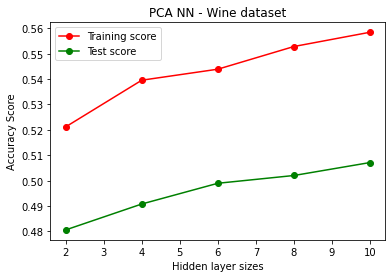

In [35]:
NN(X=X_reduced, Y=Y, plt_title='PCA NN - Wine dataset', random_seed=random_seed)

# PCA K means - NN - Wine 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.449974          0.443878
1                   4     0.449974          0.443878
2                   6     0.449974          0.443878
3                   8     0.449974          0.443878
4                  10     0.449974          0.443878
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.4499744767738642, 0.4499744767738642, 0.4499744767738642, 0.4499744767738642, 0.4499744767738642]
test_score:  [0.44387755102040816, 0.44387755102040816, 0.44387755102040816, 0.44387755102040816, 0.44387755102040816]


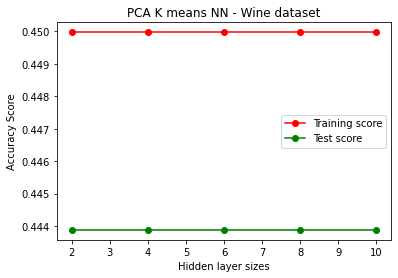

In [36]:
# Using labels from k means as feature X
NN(X=labels_pred_k, Y=Y, plt_title='PCA K means NN - Wine dataset', random_seed=random_seed)

# PCA with EM - Wine Dataset

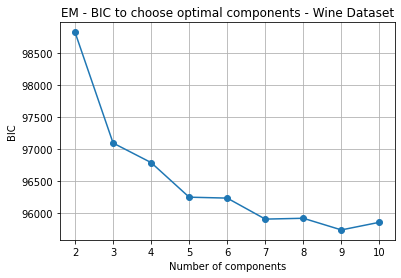

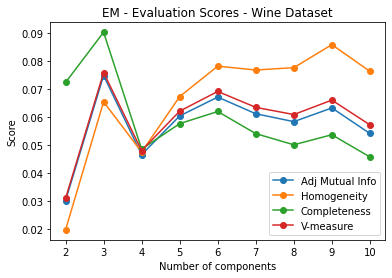

In [37]:
em(X=X_reduced, Y=Y, random_seed=random_seed, ds_name='Wine Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'EM clusters - Wine Dataset')

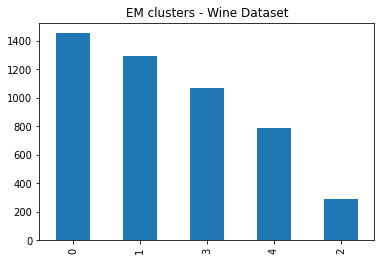

In [38]:
#Choosing components = 5 where BIC lowers significantly
gmm1 = GMM(n_components=5, random_state=random_seed)
gmm1.fit(X_reduced)
labels_pred_em = pd.DataFrame(data = gmm1.predict(X_reduced), columns=['Cluster labels'])
labels_pred_em['Cluster labels'].value_counts().plot('bar')
plt.title('EM clusters - Wine Dataset')

# PCA EM - NN - Wine

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.449974          0.443878
1                   4     0.449974          0.443878
2                   6     0.466309          0.451020
3                   8     0.466309          0.451020
4                  10     0.466309          0.451020
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.4499744767738642, 0.4499744767738642, 0.4663093415007657, 0.4663093415007657, 0.4663093415007657]
test_score:  [0.44387755102040816, 0.44387755102040816, 0.45102040816326533, 0.45102040816326533, 0.45102040816326533]


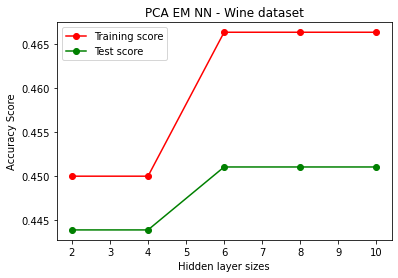

In [39]:
# Using labels from EM as feature X
NN(X=labels_pred_em, Y=Y, plt_title='PCA EM NN - Wine dataset', random_seed=random_seed)

# ***Seeds Dataset***

# Load Seeds Data

In [40]:
random_seed = 1
seeds = 'Seed_Data.csv'
df2 = pd.read_csv(seeds)
X2 = df2.iloc[:, :-1]
Y2 = df2.iloc[:, -1]
# Standardize
X_std2 = StandardScaler().fit_transform(X2)
X_std2 = pd.DataFrame(data=X_std2, columns=X2.columns)
X_std2.shape
# X, X_test, Y, Y_test = train_test_split(data_X, data_y, train_size=0.8, random_state=random_seed)

(210, 7)

# PCA - Seeds dataset

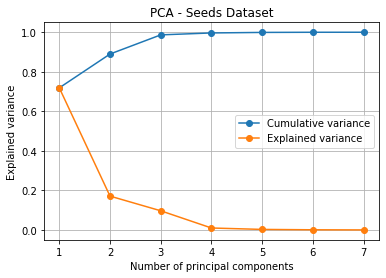

1 2 3 4 5 6 7
PCA - cum variance
[0.7187430265675439, 0.8898248618491236, 0.9866824959320444, 0.9964488497880598, 0.9991222225027362, 0.9998839433143608, 0.9999999999999999]
PCA - variance
[7.18743027e-01 1.71081835e-01 9.68576341e-02 9.76635386e-03
 2.67337271e-03 7.61720812e-04 1.16056686e-04]
Principal components - Fit times
[0.001809, 0.001798, 0.001578, 0.001656, 0.001617, 0.001732, 0.001601]


In [41]:
pca(X=X_std2, Y=Y2, random_seed=random_seed, no_features=7, ds_name = 'Seeds Dataset')

# PCA with K means - Seeds Dataset

Seeds Dataset choosing Principal components = 2 (cum_var = 0.8898248)

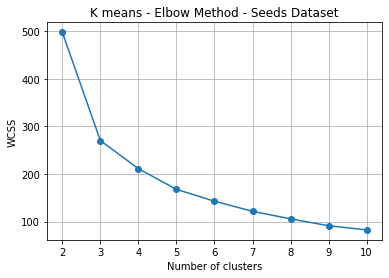

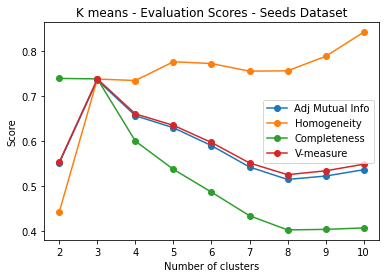

In [42]:
pca2 = PCA(n_components=2)
pca2.fit(X_std2)
X_reduced2 = pca2.transform(X_std2)
np.sum(pca2.explained_variance_ratio_)

kmeans(X=X_reduced2, Y=Y2, random_seed=random_seed, ds_name='Seeds Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'K means clusters - Wine Dataset')

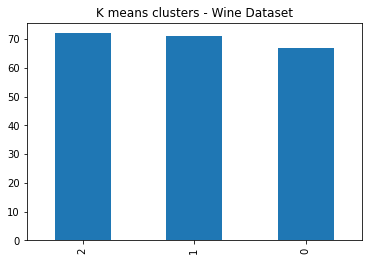

In [43]:
# Choosing k=3 appx from elbow and score peak
kmeans2 = KMeans(n_clusters=3, init='k-means++', random_state=random_seed)
kmeans2.fit(X_reduced2)
labels_pred = pd.DataFrame(data = kmeans2.labels_, columns=['Cluster labels'])
labels_pred['Cluster labels'].value_counts().plot('bar')
plt.title('K means clusters - Wine Dataset')

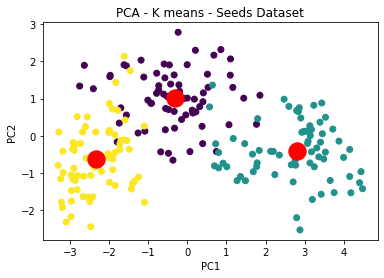

In [44]:
# Visualization of clusters & labels using PCA
plt.title("PCA - K means - Seeds Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(X_reduced2[:,0], X_reduced2[:,1], c=Y2)
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], s=300, c='red')

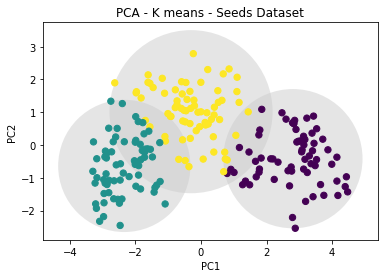

In [45]:
#plt.title("PCA - K means - Seeds Dataset")
#plt.xlabel("PC1")
#plt.ylabel("PC2")
plot_kmeans(kmeans=kmeans2, X=X_reduced2, n_clusters=3, rseed=random_seed, ds_name='Seeds Dataset')

# PCA with EM - Seeds Dataset

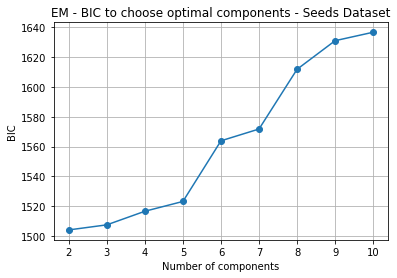

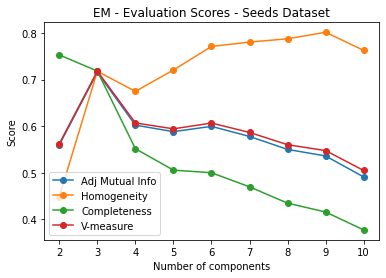

In [46]:
em(X=X_reduced2, Y=Y2, random_seed=random_seed, ds_name='Seeds Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'EM clusters - Seeds Dataset')

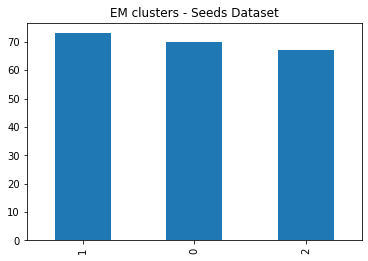

In [47]:
#Choosing components = 3 where BIC lowers significantly
gmm2 = GMM(n_components=3, random_state=random_seed)
gmm2.fit(X_reduced2)
labels_pred = pd.DataFrame(data = gmm2.predict(X_reduced2), columns=['Cluster labels'])
labels_pred['Cluster labels'].value_counts().plot('bar')
plt.title('EM clusters - Seeds Dataset')

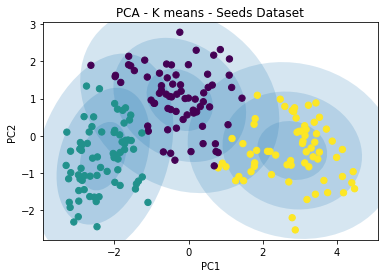

In [48]:
plot_gmm(gmm=gmm2, X=X_reduced2, ds_name='Seeds Dataset')